In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   print("GPU available")
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 30  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [3]:
t = 0
for line in open('../large_files/translation/cmn.txt', encoding='utf-8'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, _ = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation 
  target_text_input = translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [4]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 3472 unique input tokens.


In [5]:
max_len_input = max(len(s) for s in input_sequences)

In [6]:
#for chinese, using jieba to tokenize => establish word2idx => establish target sequences

In [7]:
import jieba

In [8]:
stop_words = []
with open('../corpus/stop_words.txt') as f:
    for line in f:
        stop_words.append(line.rstrip())

In [9]:
target_seg = []
target_input_seg = []
for t in target_texts:
    seg = jieba.lcut(t)
    seg = [s for s in seg if s not in stop_words]
    target_seg.append(seg + ['<eos>'])
    target_input_seg.append(['<sos>'] + seg)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\AMOCH~1.LIU\AppData\Local\Temp\jieba.cache
Loading model cost 0.560 seconds.
Prefix dict has been built successfully.


In [10]:
word2idx_outputs = {}

for L in target_seg:
    for token in L + ['<sos>']:
        if token not in word2idx_outputs:
            word2idx_outputs[token] = len(word2idx_outputs) + 1

In [11]:
target_sequences = []
target_input_sequences = []

for L in target_seg:
    sequence = []
    for seg in L:
        sequence.append(word2idx_outputs.get(seg))
    target_sequences.append(sequence)

for L in target_input_seg:
    sequence = []
    for seg in L:
        sequence.append(word2idx_outputs.get(seg))
    target_input_sequences.append(sequence)

In [12]:
# get the word to index mapping for output language
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 6651 unique output tokens.


In [13]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_input_sequences, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 9)
encoder_inputs[0]: [  0   0   0   0   0   0   0   0 911]
decoder_inputs[0]: [3 1 0 0 0 0 0 0 0 0 0 0 0]
decoder_inputs.shape: (10000, 13)


In [14]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [15]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [16]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [17]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [18]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  recurrent_dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  recurrent_dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 9, 100)       347300      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 13, 256)      1702912     input_2[0][0]                    
____________________________________________________________________________________________

In [20]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
    mask = K.cast(y_true > 0, dtype='float32')
    out = mask * y_true * K.log(y_pred)
    return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
    targ = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

In [21]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)


Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 10s 1ms/step - loss: 3.1057 - acc: 0.0833 - val_loss: 2.9731 - val_acc: 0.1818
Epoch 2/30
8000/8000 [==============================] - 9s 1ms/step - loss: 2.1665 - acc: 0.2392 - val_loss: 2.8987 - val_acc: 0.1996
Epoch 3/30
8000/8000 [==============================] - 9s 1ms/step - loss: 2.0679 - acc: 0.2516 - val_loss: 2.8666 - val_acc: 0.2086
Epoch 4/30
8000/8000 [==============================] - 9s 1ms/step - loss: 1.9696 - acc: 0.2682 - val_loss: 2.8081 - val_acc: 0.2341
Epoch 5/30
8000/8000 [==============================] - 9s 1ms/step - loss: 1.8644 - acc: 0.3055 - val_loss: 2.7438 - val_acc: 0.2614
Epoch 6/30
8000/8000 [==============================] - 9s 1ms/step - loss: 1.7590 - acc: 0.3405 - val_loss: 2.6989 - val_acc: 0.2891
Epoch 7/30
8000/8000 [==============================] - 9s 1ms/step - loss: 1.6570 - acc: 0.3700 - val_loss: 2.6585 - val_acc: 0.3017
Epoch 8/30
8

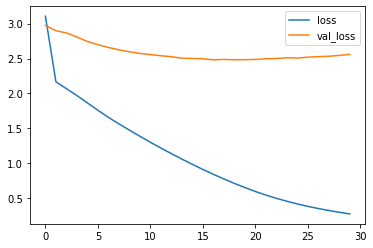

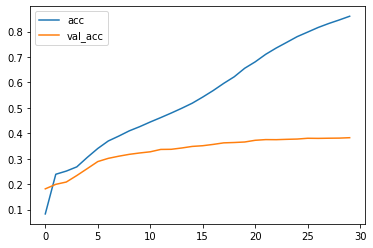

In [22]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')


In [23]:
# from keras.models import load_model
# import keras.losses
# keras.losses.custom_loss = custom_loss

# model = load_model('s2s.h5')

In [24]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I love music.
Translation: 我 愛 音乐
Continue? [Y/n]y
-
Input: She was run over by a car.
Translation: 她 被 車子 輾過 了
Continue? [Y/n]y
-
Input: Can you see?
Translation: 你 能 去 吗
Continue? [Y/n]y
-
Input: I'll try to meet your wishes.
Translation: 我會 帶 你 的 幫助
Continue? [Y/n]y
-
Input: I forgot to ask Tom.
Translation: 我 請 汤姆 忘 了
Continue? [Y/n]y
-
Input: My job is washing dishes.
Translation: 我 的 工作 是 洗 盤子
